In [1]:
import pandas as pd
import numpy as np
import json
import re
import urllib2
import geopandas as gp
from shapely.geometry import Point
import matplotlib.pyplot as plt
%matplotlib inline

In [678]:
data_path = "./Capstone - Taxi Relief Stand/Data/Parking Tickets"

In [679]:
vio_codes = pd.read_csv(data_path + "/DOF_Parking_Violation_Codes.csv")

In [680]:
vio = pd.read_csv(data_path + "/Parking_Ticket_2016.csv")

In [681]:
vio['Plate Type'].unique()

array(['999', 'PAS', 'OMT', 'COM', 'TRL', 'OML', 'OMS', 'FAR', 'APP',
       'OMF', 'ORC', 'OMV', 'OMR', 'CBS', 'MOT', 'SRF', 'TRC', 'TOW'], dtype=object)

In [682]:
vio = vio[vio['Plate Type'] == 'OMT']

In [683]:
len(vio)

32360

In [684]:
vio = vio.loc[:,['Summons Number', 'House Number', 'Street Name', 'Intersecting Street', 'Issue Date']]

In [685]:
vio.reset_index(inplace=True, drop=True)

In [98]:
data_path = "./Capstone - Taxi Relief Stand/Data_Warehouse/Parking Tickets"
vio_2015 = pd.read_csv(data_path + "/parking_violations_taxi_2015.csv")

In [99]:
vio_2015 = vio_2015.loc[:,['Summons Number', 'House Number', 'Street Name', 'Intersecting Street', 'Issue Date']]

In [100]:
vio_2015['Issue Date'] = pd.to_datetime(vio_2015['Issue Date'])
vio_2015 = vio_2015[vio_2015['Issue Date'] >= '2015-01-01']

In [101]:
vio_2015['Issue Date'].describe()

count                   31765
unique                    181
top       2015-01-14 00:00:00
freq                      479
first     2015-01-01 00:00:00
last      2015-06-30 00:00:00
Name: Issue Date, dtype: object

## Address = House no. + Street name
## However, in some cases House no. is missing, so we use intersection street
## We are adding New York at the end of the address
## IF housing no. is NaN, we use intersection street - by adding '&' and 'st new york'

In [104]:
def create_address(data):
    
    if ( (type(data['Intersecting Street']) == str) & (type(data['Street Name']) == str)):
        add =  (data['Intersecting Street'] + ' %26 ' + data['Street Name'] + ' st New York NY')
        add = add.upper()
        add_re = re.findall((r"\w*\s.*/O.*?\s(.*)"),add)    
        if len(add_re) == 0:
            return add
        else:
            return add_re[0]
    
    elif ((type(data['Street Name']) == str) & (type(data['House Number']) == str)):
        add = (str(data['House Number']) + ' ' + data['Street Name'] + ' New York NY')
        add = add.upper()
        add_re = re.findall((r"\w*\s.*/O.*?\s(.*)"),add)
        if len(add_re) == 0:
            return add
        else:
            return add_re[0]
    else:
        return ''

In [796]:
vio.loc[:,'Address'] = vio.apply(create_address, axis=1)

In [105]:
vio_2015.loc[:,'Address'] = vio_2015.apply(create_address, axis=1)

In [106]:
len(vio_2015)

31765

In [107]:
vio_2015.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31765 entries, 2 to 63305
Data columns (total 6 columns):
Summons Number         31765 non-null int64
House Number           20443 non-null object
Street Name            31763 non-null object
Intersecting Street    14743 non-null object
Issue Date             31765 non-null datetime64[ns]
Address                31765 non-null object
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.7+ MB


In [797]:
vio.head()

,Summons Number,House Number,Street Name,Intersecting Street,Issue Date,Address
0,1131604908,93-02,SUTPHIN BLVD,NaN,06/30/2015,93-02 sutphin blvd new york ny
1,1255154809,NaN,E 125,PARK AVE,06/20/2015,park ave %26 e 125 st new york ny
2,1359750186,34-14,64 ST,NaN,07/01/2015,34-14 64 st new york ny
3,1362784618,90-15,QUEENS BLVD,NaN,07/21/2015,90-15 queens blvd new york ny
4,1362806274,90-15,QUEENS BLVD,NaN,07/19/2015,90-15 queens blvd new york ny


In [798]:
vio = vio[vio.Address != '']

In [109]:
vio_2015_blank = vio_2015[vio_2015.Address == '']

In [110]:
vio_2015 = vio_2015[vio_2015.Address != '']

In [111]:
add_2015_uni = vio_2015.Address.unique()

In [112]:
len(add_2015_uni)

8998

In [799]:
address_uni = vio.Address.unique()

In [800]:
len(address_uni)

14612

In [801]:
add_uni_api = map(lambda x: x.replace(" ", "+"),address_uni)

In [114]:
add_2015_uni_api = map(lambda x: x.replace(" ", "+"),add_2015_uni)

In [116]:
len(add_uni_api)

In [803]:
add_df = pd.DataFrame([address_uni, add_uni_api]).T

In [117]:
add_2015_df = pd.DataFrame([add_2015_uni, add_2015_uni_api]).T

In [118]:
add_2015_df.columns = ['add_uni', 'add_uni_api']
add_2015_df.head()

,add_uni,add_uni_api
0,626 10TH AVE NEW YORK NY,626+10TH+AVE+NEW+YORK+NY
1,213 PARK AVE SOUTH NEW YORK NY,213+PARK+AVE+SOUTH+NEW+YORK+NY
2,150 2ND AVE NEW YORK NY,150+2ND+AVE+NEW+YORK+NY
3,2477 VALENTINE AVE NEW YORK NY,2477+VALENTINE+AVE+NEW+YORK+NY
4,16714 HILLSIDE AVE NEW YORK NY,16714+HILLSIDE+AVE+NEW+YORK+NY


In [120]:
add_df.columns = ['add_uni', 'add_uni_api']
add_df.head()

In [137]:
f = open('./API_key.txt', 'r')
key = f.readlines()[0]

In [903]:
add_df.reset_index(inplace=True, drop=True)

In [122]:
def geo_coder(start, stop, add_df):
    
    for i in range(start, stop):

        print '\r',str(i),
        add = add_df.loc[i,'add_uni_api']
        url = "https://maps.googleapis.com/maps/api/geocode/json?address=" + add + \
"&components=country:US&key=" + key
    
        response = urllib2.urlopen(url)
        data = response.read().decode("utf-8")
        info = json.loads(data)
        if info['status'] == 'ZERO_RESULTS':
            add_df.loc[i,'lat'] = 0
            add_df.loc[i,'lng'] = 0
    
        elif info['status'] == 'OK': 
    
            try:
                add_df.loc[i,'lat'] = info['results'][0]['geometry']['location']['lat']
                add_df.loc[i,'lng'] = info['results'][0]['geometry']['location']['lng']
    
            except IndexError:
                print "Some issue"
                pass
        
        elif info['status'] == 'OVER_QUERY_LIMIT':
            print "Done with limit"
            break
        
    return add_df

In [123]:
len(add_2015_df)

8998

In [125]:
add_2015_df = geo_coder(0,2500,add_2015_df)

2479 Done with limit


In [130]:
add_2015_df = geo_coder(2479, 4979, add_2015_df)

4971 Done with limit


In [133]:
add_2015_df = geo_coder(6148, 7471, add_2015_df)

7444 Done with limit


In [140]:
add_2015_df = geo_coder(8996, 8999, add_2015_df)

In [143]:
add_2015_df[add_2015_df.lng == 0]

,add_uni,add_uni_api,lat,lng
2264,3RD AVE %26 E 29TH ST ST NEW YORK NY,3RD+AVE+%26+E+29TH+ST+ST+NEW+YORK+NY,0.0,0.0
5894,35-23 36TH ST NEW YORK NY,35-23+36TH+ST+NEW+YORK+NY,0.0,0.0


In [144]:
add_2015_df = geo_coder(2264, 2265, add_2015_df)

2264


In [145]:
add_2015_df = geo_coder(5894, 5895, add_2015_df)

5894


In [146]:
add_2015_df[add_2015_df.lng == 0]

,add_uni,add_uni_api,lat,lng


In [150]:
wrong_index = add_2015_df[add_2015_df.lng == add_2015_df.lng.value_counts().index[0]].index

In [927]:
# wrong_index = add_df[add_df.lng == v.index[0]].index

In [154]:
def geo_coder_index(wrong_index, add_df):

    for i in wrong_index:

        print '\r',str(i),
        add = add_df.loc[i,'add_uni_api']
        url = "https://maps.googleapis.com/maps/api/geocode/json?address=" + add + \
"&components=country:US&key=" + key
    
        response = urllib2.urlopen(url)
        data = response.read().decode("utf-8")
        info = json.loads(data)
        if info['status'] == 'ZERO_RESULTS':
            add_df.loc[i,'lat'] = 0
            add_df.loc[i,'lng'] = 0
    
        elif info['status'] == 'OK': 
    
            try:
                add_df.loc[i,'lat'] = info['results'][0]['geometry']['location']['lat']
                add_df.loc[i,'lng'] = info['results'][0]['geometry']['location']['lng']
    
            except IndexError:
                print "Some issue"
                pass
        
        elif info['status'] == 'OVER_QUERY_LIMIT':
            print "Done with limit"
            break
    
    return add_df

In [155]:
add_2015_df.loc[wrong_index] = geo_coder_index(wrong_index, add_2015_df)

8948


In [162]:
# add_df_1 = add_df.loc[:10000]

# add_df_2 = pd.read_csv("./add_parking_vio_mapper_2.csv")

# add_df_2.drop(['Unnamed: 0'], axis=1, inplace=True)

# Final

In [944]:
add_df = pd.concat([add_df_1, add_df_2], ignore_index=True)

In [948]:
v = add_df.lat.value_counts()

In [957]:
wrong_index = add_df[add_df.lat == v.index[0]].index

In [959]:
for i in wrong_index:

    print '\r',str(i),
    add = add_df.loc[i,'add_uni_api']
    url = "https://maps.googleapis.com/maps/api/geocode/json?address=" + add + \
"&components=country:US&key=" + key
    
    response = urllib2.urlopen(url)
    data = response.read().decode("utf-8")
    info = json.loads(data)
    if info['status'] == 'ZERO_RESULTS':
        add_df.loc[i,'lat'] = 0
        add_df.loc[i,'lng'] = 0
    
    elif info['status'] == 'OK': 
    
        try:
            add_df.loc[i,'lat'] = info['results'][0]['geometry']['location']['lat']
            add_df.loc[i,'lng'] = info['results'][0]['geometry']['location']['lng']
    
        except IndexError:
            print "Some issue"
            pass
        
    elif info['status'] == 'OVER_QUERY_LIMIT':
        print "Done with limit"
        break

14554


In [960]:
v = add_df.lat.value_counts()

In [964]:
add_df.to_csv("add_parking_vio_mapper.csv")

In [966]:
wr_add = gp.read_file("./wrong_address/wrong_address.shp")

In [968]:
wr_add.drop(['Field1','geometry'], axis=1, inplace=True)

In [972]:
for i in range(len(wr_add)):

    print '\r',str(i),
    add = wr_add.loc[i,'add_uni_ap']
    url = "https://maps.googleapis.com/maps/api/geocode/json?address=" + add + \
"&components=country:US&key=" + key
    
    response = urllib2.urlopen(url)
    data = response.read().decode("utf-8")
    info = json.loads(data)
    if info['status'] == 'ZERO_RESULTS':
        wr_add.loc[i,'lat'] = 0
        wr_add.loc[i,'lng'] = 0
    
    elif info['status'] == 'OK': 
    
        try:
            wr_add.loc[i,'lat'] = info['results'][0]['geometry']['location']['lat']
            wr_add.loc[i,'lng'] = info['results'][0]['geometry']['location']['lng']
    
        except IndexError:
            print "Some issue"
            pass
        
    elif info['status'] == 'OVER_QUERY_LIMIT':
        print "Done with limit"
        break

202


In [997]:
add = wr_add.loc[i,'add_uni_ap']
url = "https://maps.googleapis.com/maps/api/geocode/json?address=180+university+ave+new+york,+ny" + \
"&components=country:US&key=" + key
    
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [994]:
wr_add.loc[199,'lat'] = info['results'][0]['geometry']['location']['lat']
wr_add.loc[199,'lng'] = info['results'][0]['geometry']['location']['lng']

In [999]:
wr_add.to_csv("./wrong_address/wr_add_updated.csv")

In [1012]:
len(wr_add)

203

In [1001]:
correct_1 = gp.read_file("./correct_address/correct_address.shp")

In [1002]:
correct_2 = gp.read_file("./correct_address/correct_address_2.shp")

In [1003]:
correct_address = pd.concat([correct_1, correct_2], ignore_index=True)

In [1005]:
correct_address.drop(['Field1','geometry'], axis=1, inplace=True)

In [1007]:
len(vio)

32231

In [1008]:
len(correct_address)

14419

In [1031]:
vio_df = pd.merge(vio, correct_address, left_on='Address', right_on='add_uni')

In [164]:
vio_2015_df = pd.merge(vio_2015, add_2015_df, left_on='Address', right_on='add_uni') 

In [1032]:
len(vio_df)

31978

In [1033]:
32231 - 31978

253

In [170]:
vio_df.drop(['House Number','Street Name', 'Intersecting Street','Address', 'add_uni', 'add_uni_ap'], axis=1, inplace=True)

In [172]:
vio_2015_df.drop(['House Number','Street Name', 'Intersecting Street','Address', 'add_uni', 'add_uni_api'], axis=1, inplace=True)

In [1037]:
vio_df['Issue Date'] = pd.to_datetime(vio_df['Issue Date'])

In [173]:
vio_2015_df['Issue Date'] = pd.to_datetime(vio_2015_df['Issue Date'])

In [1043]:
vio_df = vio_df[(vio_df['Issue Date'] >= "2015-07-01") & (vio_df['Issue Date'] <= "2016-06-30")] 

In [1044]:
vio_df.reset_index(inplace=True, drop=True)

In [1045]:
vio_df.to_csv("./vio_2016.csv")

In [1053]:
vio_weel = vio_df.set_index('Issue Date').groupby([pd.TimeGrouper('D')]).agg({'Summons Number':'count'})

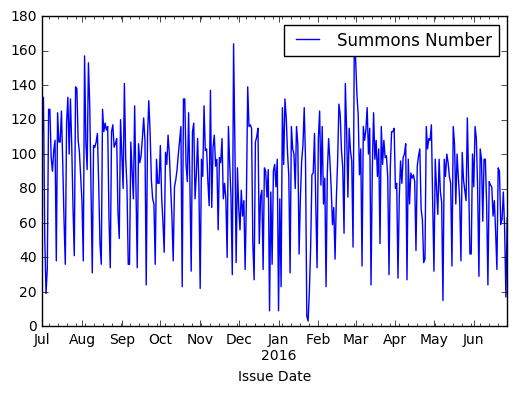

In [1054]:
vio_weel.plot()

# Merge Jan 2015 - June 2015 and July 2015 to Dec 2015 from respective dataframes

In [285]:
vio = pd.read_csv("./vio_2016.csv")
vio.drop(['Unnamed: 0'], axis=1, inplace=True)

In [286]:
vio.head()

,Summons Number,Issue Date,lat,lng
0,1131612360,2015-08-06,40.700519,-73.807702
1,1131613120,2015-08-06,40.700519,-73.807702
2,1131613132,2015-08-06,40.700519,-73.807702
3,1131613296,2015-08-07,40.700519,-73.807702
4,1131613260,2015-08-28,40.700519,-73.807702


In [287]:
vio['Issue Date'] = pd.to_datetime(vio['Issue Date'])

In [288]:
vio['Issue Date'].describe()

count                   31343
unique                    363
top       2016-02-29 00:00:00
freq                      167
first     2015-07-01 00:00:00
last      2016-06-27 00:00:00
Name: Issue Date, dtype: object

In [289]:
vio_df2 = vio[vio['Issue Date'] <= '2015-12-31']

In [290]:
vio_2015_df.head(2)

,Summons Number,Issue Date,lat,lng
0,7854353001,2015-04-03,40.761128,-73.994043
1,7064177651,2015-01-13,40.761128,-73.994043


In [291]:
vio_df2['Issue Date'].describe()

count                   16313
unique                    184
top       2015-11-27 00:00:00
freq                      164
first     2015-07-01 00:00:00
last      2015-12-31 00:00:00
Name: Issue Date, dtype: object

In [292]:
vio_2015_df['Issue Date'].describe()

count                   31603
unique                    181
top       2015-01-14 00:00:00
freq                      477
first     2015-01-01 00:00:00
last      2015-06-30 00:00:00
Name: Issue Date, dtype: object

In [293]:
vio_df_2015 = pd.concat([vio_df2, vio_2015_df], ignore_index=True)

In [294]:
vio_df_2015 = vio_df_2015.sort_values(by='Issue Date')

In [297]:
vio_df_2015.drop_duplicates(inplace=True)

In [298]:
vio_df_2015.to_csv('./violations_2015.csv')

# Merge violations with hexagons

In [5]:
vio = pd.read_csv("./violations_2015.csv")

In [6]:
vio.columns

Index([u'Unnamed: 0', u'Summons Number', u'Issue Date', u'lat', u'lng'], dtype='object')

In [7]:
vio.drop([u'Unnamed: 0'], axis=1, inplace=True)

In [8]:
len(vio)

44645

In [9]:
data_path = "./Capstone - Taxi Relief Stand/Data_Warehouse/Parking Tickets"
vio_all = pd.read_csv(data_path + "/Parking_Ticket_2016.csv")

In [10]:
data_path = "./Capstone - Taxi Relief Stand/Data_Warehouse/Parking Tickets"
vio_2015 = pd.read_csv(data_path + "/parking_violations_taxi_2015.csv")

C:\Users\Vishwajeet\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
vio_2015.columns

Index([u'Summons Number', u'Plate ID', u'Registration State', u'Plate Type',
       u'Issue Date', u'Violation Code', u'Vehicle Body Type', u'Vehicle Make',
       u'Issuing Agency', u'Street Code1', u'Street Code2', u'Street Code3',
       u'Vehicle Expiration Date', u'Violation Location',
       u'Violation Precinct', u'Issuer Precinct', u'Issuer Code',
       u'Issuer Command', u'Issuer Squad', u'Violation Time',
       u'Time First Observed', u'Violation County',
       u'Violation In Front Of Or Opposite', u'House Number', u'Street Name',
       u'Intersecting Street', u'Date First Observed', u'Law Section',
       u'Sub Division', u'Violation Legal Code', u'Days Parking In Effect    ',
       u'From Hours In Effect', u'To Hours In Effect', u'Vehicle Color',
       u'Unregistered Vehicle?', u'Vehicle Year', u'Meter Number',
       u'Feet From Curb', u'Violation Post Code', u'Violation Description',
       u'No Standing or Stopping Violation', u'Hydrant Violation',
       u'Double 

In [12]:
vio_all.columns

Index([u'Unnamed: 0', u'Summons Number', u'Plate ID', u'Registration State',
       u'Plate Type', u'Issue Date', u'Violation Code', u'Vehicle Body Type',
       u'Vehicle Make', u'Issuing Agency', u'Street Code1', u'Street Code2',
       u'Street Code3', u'Vehicle Expiration Date', u'Violation Location',
       u'Violation Precinct', u'Issuer Precinct', u'Issuer Code',
       u'Issuer Command', u'Issuer Squad', u'Violation Time',
       u'Time First Observed', u'Violation County',
       u'Violation In Front Of Or Opposite', u'House Number', u'Street Name',
       u'Intersecting Street', u'Date First Observed', u'Law Section',
       u'Sub Division', u'Violation Legal Code', u'Days Parking In Effect    ',
       u'From Hours In Effect', u'To Hours In Effect', u'Vehicle Color',
       u'Unregistered Vehicle?', u'Vehicle Year', u'Meter Number',
       u'Feet From Curb', u'Violation Post Code', u'Violation Description',
       u'No Standing or Stopping Violation', u'Hydrant Violation',
 

In [13]:
vio_all.drop([u'Unnamed: 0', u'Plate ID', u'Registration State',
       u'Plate Type', u'Issue Date', u'Vehicle Body Type',
       u'Vehicle Make', u'Issuing Agency', u'Street Code1', u'Street Code2',
       u'Street Code3', u'Vehicle Expiration Date', u'Violation Location',
       u'Violation Precinct', u'Issuer Precinct', u'Issuer Code',
       u'Issuer Command', u'Issuer Squad', u'Violation Time',
       u'Time First Observed', u'Violation County',
       u'Violation In Front Of Or Opposite', u'House Number', u'Street Name',
       u'Intersecting Street', u'Date First Observed', u'Law Section',
       u'Sub Division', u'Violation Legal Code', u'Days Parking In Effect    ',
       u'From Hours In Effect', u'To Hours In Effect', u'Vehicle Color',
       u'Unregistered Vehicle?', u'Vehicle Year', u'Meter Number',
       u'Feet From Curb', u'Violation Post Code', u'Violation Description',
       u'No Standing or Stopping Violation', u'Hydrant Violation',
       u'Double Parking Violation', u'Address'], axis=1, inplace=True)

In [14]:
vio_2015.drop([u'Plate ID', u'Registration State',
       u'Plate Type', u'Issue Date', u'Vehicle Body Type',
       u'Vehicle Make', u'Issuing Agency', u'Street Code1', u'Street Code2',
       u'Street Code3', u'Vehicle Expiration Date', u'Violation Location',
       u'Violation Precinct', u'Issuer Precinct', u'Issuer Code',
       u'Issuer Command', u'Issuer Squad', u'Violation Time',
       u'Time First Observed', u'Violation County',
       u'Violation In Front Of Or Opposite', u'House Number', u'Street Name',
       u'Intersecting Street', u'Date First Observed', u'Law Section',
       u'Sub Division', u'Violation Legal Code', u'Days Parking In Effect    ',
       u'From Hours In Effect', u'To Hours In Effect', u'Vehicle Color',
       u'Unregistered Vehicle?', u'Vehicle Year', u'Meter Number',
       u'Feet From Curb', u'Violation Post Code', u'Violation Description',
       u'No Standing or Stopping Violation', u'Hydrant Violation',
       u'Double Parking Violation'], axis=1, inplace=True)

In [15]:
len(vio_all)

33806

In [16]:
len(vio_2015)

63309

In [17]:
vio_2015.drop_duplicates(inplace=True)

In [18]:
len(vio_2015)

59025

In [19]:
len(vio)

44645

In [20]:
vio_all = pd.concat([vio_2015, vio_all], ignore_index=True)

In [21]:
len(vio)

44645

In [22]:
len(vio_all)

92831

In [23]:
vio = pd.merge(vio, vio_all, on='Summons Number')

In [24]:
len(vio)

45287

In [25]:
vio.drop_duplicates(inplace = True)

In [26]:
vio.columns

Index([u'Summons Number', u'Issue Date', u'lat', u'lng', u'Violation Code'], dtype='object')

In [27]:
vio.head()

,Summons Number,Issue Date,lat,lng,Violation Code
0,5084467648,2015-01-01,40.681834,-73.975838,7
1,5084465937,2015-01-01,40.621994,-73.994920,7
2,5084467235,2015-01-01,40.678797,-73.953002,7
3,5084474409,2015-01-01,40.739792,-73.979542,7
4,5084472267,2015-01-01,40.776024,-73.987242,7


In [28]:
len(vio)

44645

In [37]:
vio['Violation Code'].value_counts().index.sort_values()

Int64Index([ 5,  7,  8,  9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 23, 24, 26,
            27, 31, 34, 36, 37, 38, 39, 40, 41, 45, 46, 47, 48, 49, 50, 51, 52,
            53, 55, 60, 61, 62, 64, 65, 67, 68, 70, 71, 72, 73, 74, 75, 79, 80,
            98],
           dtype='int64')

In [38]:
ind = [6,10,11, 12,13,14,16,17,18,19,20,21,22,23,24,27,32,33,34,35,39,40,42,43,44,45,46,47,48,49,50,51,52,53,55,56,57,58,59,
60,61,62,63,66,67,68,70,71,72,73,74,75,77,78,80,82,83,84,85,86,89,91,92,93,96,97,98,99,37,38]

In [39]:
vio[vio['Violation Code'].isin(ind)]

,Summons Number,Issue Date,lat,lng,Violation Code
50,7825976496,2015-01-02,40.744230,-73.986841,23
51,7130789529,2015-01-02,40.777556,-73.948885,50
53,7565917291,2015-01-02,40.890506,-73.859308,38
54,7855158686,2015-01-02,40.743806,-73.996259,13
55,7839592958,2015-01-02,40.762391,-73.978607,14
56,7329115022,2015-01-02,40.752111,-73.944251,20
57,7322584119,2015-01-02,40.822179,-73.939662,20
58,8004076713,2015-01-02,40.705103,-73.806174,38
60,7977176695,2015-01-02,40.804614,-73.947884,21
62,7839592946,2015-01-02,40.761788,-73.980034,14


In [3]:
vio = pd.read_csv("./violations_2015.csv")

In [325]:
vio_codes = pd.read_csv(data_path + "/DOF_Parking_Violation_Codes.csv")

# Hexagons

In [330]:
hexagons = gp.read_file('./Capstone - Taxi Relief Stand/Data_Warehouse/Hexagon_Shapefile_4003/hexagons_clipped.shp')

In [331]:
hexagons.head(2)

,GRID_ID,Id,geometry
0,BZ-45,0,"POLYGON ((1014951.499084486 205223.478088384, ..."
1,CC-66,0,"POLYGON ((1018899.721130365 172550.5435180648,..."


In [335]:
hexagons = hexagons.to_crs(epsg=4326)
hexagons.crs

{'init': 'epsg:4326', 'no_defs': True}

In [343]:
vio_hex = gp.sjoin(vio, hexagons)
vio_hex.columns
vio_hex.drop([u'index_right', u'Id'], axis = 1, inplace = True)
vio_hex['Issue Date'] = pd.to_datetime(vio_hex['Issue Date'])
(vio_hex['Issue Date']).describe()

count                   41545
unique                    365
top       2015-03-02 00:00:00
freq                      209
first     2015-01-01 00:00:00
last      2015-12-31 00:00:00
Name: Issue Date, dtype: object

In [360]:
vio_codes_hex = vio_hex.groupby(['GRID_ID', 'Violation Code']).agg({'Summons Number':'count'})
vio_codes_hex.reset_index(inplace=True)
vio_codes_hex[vio_codes_hex.GRID_ID == 'BG-42'].sort_values(by='Summons Number', ascending=False)

,GRID_ID,Violation Code,Summons Number
1491,BG-42,23,1257
1495,BG-42,38,207
1484,BG-42,13,119
1489,BG-42,20,72
1497,BG-42,40,59
1499,BG-42,46,43
1494,BG-42,37,31
1490,BG-42,21,25
1487,BG-42,17,24
1485,BG-42,14,21


In [356]:
vio_hex.to_csv("./violations_nyc_2015.csv")

# Manhattan hexagons

In [364]:
vio = pd.read_csv("./violations_2015.csv")
vio.drop([u'Unnamed: 0'], axis=1, inplace=True)

In [365]:
manhattan = pd.read_csv("./Capstone - Taxi Relief Stand/Data_Warehouse/Other_Data/manhattan.csv")

In [366]:
crs = {'init': 'epsg:4326', 'no_defs': True}
manhattan = gp.GeoDataFrame(manhattan, crs=crs)
manhattan.crs

{'init': 'epsg:4326', 'no_defs': True}

In [367]:
crs = {'init': 'epsg:4326', 'no_defs': True}
geometry = [Point(xy) for xy in zip(vio["lng"], vio["lat"])]
vio = vio.drop(["lng", "lat"], axis=1)
vio = gp.GeoDataFrame(vio, crs=crs, geometry=geometry)

In [368]:
vio.crs

{'init': 'epsg:4326', 'no_defs': True}

In [369]:
vio.head()

,Summons Number,Issue Date,geometry
0,5084467648,2015-01-01,POINT (-73.97583840000002 40.6818342)
1,5084465937,2015-01-01,POINT (-73.99491999999999 40.621994)
2,5084467235,2015-01-01,POINT (-73.9530018 40.6787972)
3,5084474409,2015-01-01,POINT (-73.9795422 40.7397923)
4,5084472267,2015-01-01,POINT (-73.9872417 40.7760243)


In [377]:
manhattan_grids = manhattan.GRID_ID.values

In [379]:
vio_hex_ts = gp.sjoin(hexagons, vio)

In [408]:
vio_hex_ts.to_csv('./vio_nyc_ts.csv')

In [388]:
manhattan_vio_ts = vio_hex_ts[vio_hex_ts.GRID_ID.isin(manhattan_grids)]

In [397]:
manhattan_vio_ts['Issue Date'] = pd.to_datetime(manhattan_vio_ts['Issue Date'])

C:\Users\Vishwajeet\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [398]:
manhattan_vio_ts["Issue Date"].describe()

count                   28820
unique                    365
top       2015-01-15 00:00:00
freq                      163
first     2015-01-01 00:00:00
last      2015-12-31 00:00:00
Name: Issue Date, dtype: object

In [402]:
manhattan_vio_ts = manhattan_vio_ts.groupby(['GRID_ID', 'Issue Date']).agg({'geometry':'first', 
                                                          'index_right':'count'})

In [403]:
manhattan_vio_ts.reset_index(inplace=True)

In [404]:
manhattan_vio_ts.to_csv("./manhattan_violations_timeseries.csv")